In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import numpy
import healpy
import astropy.coordinates as apco
import astropy.io.ascii
from astropy.table import Table, Column
import gaia_tools.load, gaia_tools.select
from gaia_tools import xmatch
from galpy.util import bovy_plot, bovy_coords
%pylab inline
from matplotlib.colors import LogNorm
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import NullFormatter
from matplotlib import gridspec
save_figures= False
numpy.random.seed(1)
nside= 2**5

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# The *TGAS* selection function

## Observational procedures and their relevance to the *TGAS* selection function

We start by constructing *from the TGAS data themselves* properties of the observational procedure that are relevant for the selection function. These are the number of along-scan (AL) observations (and their spread) and the diversity of scan directions as a function of sky location. We also consider the mean parallax uncertainty, mean *J* magnitude, mean $J-K_s$ color as a function of position on the sky. We do all of this in a HEALPixelization at level Nside = 2^5, which is high enough resolution to clearly display the sky dependence (which can be sharp) but low enough to have good statistics. The pixel for each *TGAS* source can be obtained from the source_id field in the *TGAS* data release. For definiteness, we compute all of these statistics based on stars with $6 < J < 10$ and $0 < J-K_s < 0.8$, because we will then compare the overall completeness compared to 2MASS based on this sample.

In [3]:
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
sid= (tgas['source_id']/2**(35.+2*(12.-numpy.log2(nside)))).astype('int')
# Just use 6 < J < 10 and 0 < J-K_s < 0.8
findx= (jk > 0.)*(jk < 0.8)*(twomass['j_mag'] > 6.)*(twomass['j_mag'] < 10.)
# Number of AL observations and their spread, divide by 9 because there are 9 separate astrometric CCDs
nobs, e= numpy.histogram(sid[findx],range=[-0.5,healpy.nside2npix(nside)-0.5],bins=healpy.nside2npix(nside),
                         weights=(tgas['astrometric_n_good_obs_al'][findx])/9.)
nobs2, e= numpy.histogram(sid[findx],range=[-0.5,healpy.nside2npix(nside)-0.5],bins=healpy.nside2npix(nside),
                          weights=((tgas['astrometric_n_good_obs_al'][findx])/9.)**2.)
nstar, e= numpy.histogram(sid[findx],range=[-0.5,healpy.nside2npix(nside)-0.5],bins=healpy.nside2npix(nside))
nobs/= nstar
nobs_std= numpy.sqrt(nobs2/nstar-nobs**2.)
# spread in the scan directions
mscd, e= numpy.histogram(sid[findx],
                        range=[-0.5,healpy.nside2npix(nside)-0.5],bins=healpy.nside2npix(nside),
                        weights=tgas['scan_direction_strength_k4'][findx])
mscd/= nstar
# Mean parallax uncertainty
mplxerr, e= numpy.histogram(sid[findx],range=[-0.5,healpy.nside2npix(nside)-0.5],bins=healpy.nside2npix(nside),
                            weights=(tgas['parallax_error'][findx]))
mplxerr/= nstar
# Mean J
mj, e= numpy.histogram(sid[findx],range=[-0.5,healpy.nside2npix(nside)-0.5],bins=healpy.nside2npix(nside),
                       weights=twomass['j_mag'][findx])
mj/= nstar
# Mean J-K_s
mjk, e= numpy.histogram(sid[findx],
                        range=[-0.5,healpy.nside2npix(nside)-0.5],bins=healpy.nside2npix(nside),
                        weights=jk[findx])
mjk/= nstar
# Also compute ecliptic coordinates
tmp_decs, ras= healpy.pix2ang(nside,numpy.arange(healpy.nside2npix(nside)),nest=True)
cos= apco.SkyCoord(ras,numpy.pi/2.-tmp_decs,unit="rad")
cos= cos.transform_to(apco.GeocentricTrueEcliptic)
elats= cos.lat.to('deg').value
elon= cos.lon.to('deg').value

Now we plot how these properties vary over the sky:

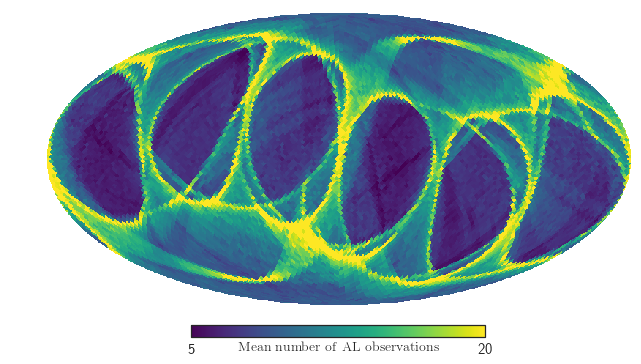

In [4]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
cmap= cm.viridis
cmap.set_under('w')
healpy.mollview(nobs,nest=True,unit=r'$\mathrm{Mean\ number\ of\ AL\ observations}$',
                cmap=cmap,min=5.,max=20.,title="")
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','nobs.pdf'),bbox_inches='tight')

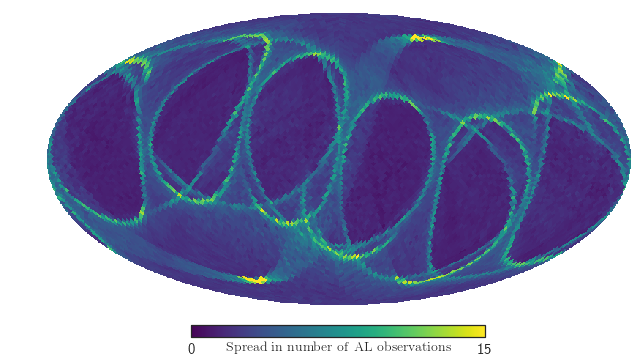

In [5]:
healpy.mollview(nobs_std,nest=True,unit=r'$\mathrm{Spread\ in\ number\ of\ AL\ observations}$',
                cmap=cmap,min=0.,max=15.,title="")
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','nobs_std.pdf'),bbox_inches='tight')

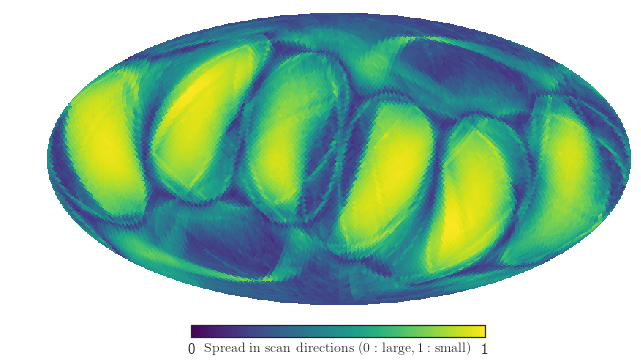

In [6]:
healpy.mollview(mscd,nest=True,unit=r'$\mathrm{Spread\ in\ scan\ directions\ (0: large, 1: small)}$',
                cmap=cmap,min=0.,max=1.,title="")
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','scank4.pdf'),bbox_inches='tight')

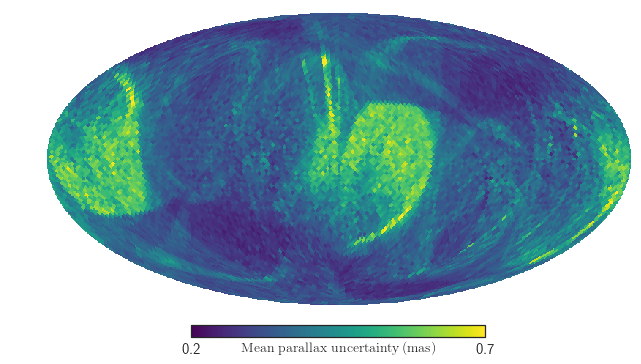

In [7]:
healpy.mollview(mplxerr,nest=True,unit=r'$\mathrm{Mean\ parallax\ uncertainty}\,(\mathrm{mas})$',
                cmap=cmap,min=0.2,max=.7,title="")
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','plxerr.pdf'),bbox_inches='tight')

Now we will get counts in 2MASS in the $6 < J < 10$ and $0 < J-K_s < 0.8$ range to get a sense of the overall completeness of different regions of the sky and how this correlates with the parameters of the observational procedure shown above.

In [8]:
# The following needs to be performed on the server with the 2MASS database, note that the " might get messed up
"""
import psycopg2
conn= psycopg2.connect("dbname=catalogs user=postgres")
cur= conn.cursor()
cur.execute("select floor(hp12index/16384), count(*) as count \
from twomass_psc, twomass_psc_hp12 \
where (twomass_psc.pts_key = twomass_psc_hp12.pts_key \
AND (ph_qual like 'A__' OR (rd_flg like '1__' OR rd_flg like '3__')) \
AND (ph_qual like '__A' OR (rd_flg like '__1' OR rd_flg like '__3')) AND use_src='1' AND ext_key is null \
AND (j_m-k_m) > 0.0 AND (j_m-k_m) < 0.8 AND j_m > 6 AND j_m < 10) \
group by floor(hp12index/16384) \
order by floor(hp12index/16384) ASC;")
import numpy
a= numpy.array(cur.fetchall(),dtype='float')
numpy.savetxt('2massc_hp5.txt',a)
"""
a= numpy.loadtxt('2massc_hp5.txt').T
# Make sure all HEALPix bins are represented (this is the case, but just to make sure)
ta= numpy.zeros((2,healpy.nside2npix(nside)))
ta[0][a[0].astype('int')]= a[0]
ta[1][a[0].astype('int')]= a[1]
a= ta

The counts in this range in *TGAS* and *2MASS* are:

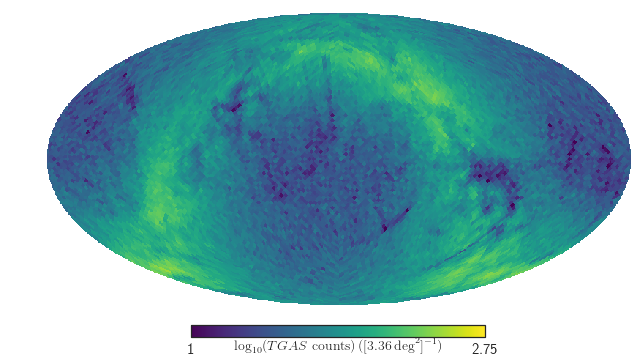

In [9]:
healpy.mollview(numpy.log10(nstar),nest=True,
                unit=r'$\log_{10} (TGAS\ \mathrm{counts})\,([%.2f\,\mathrm{deg}^2]^{-1})$' \
                    % (healpy.nside2pixarea(nside,degrees=True)),
                cmap=cmap,min=1.,max=2.75,title="")
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','tgas_counts.pdf'),bbox_inches='tight')

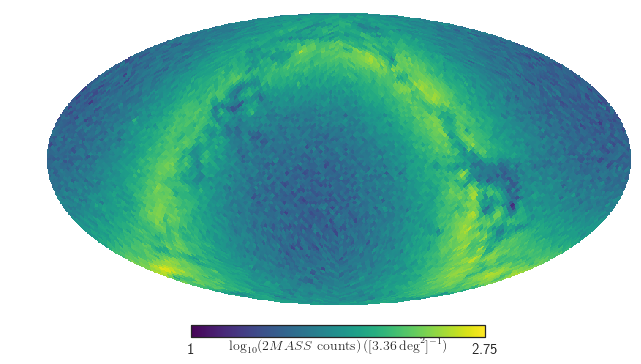

In [10]:
healpy.mollview(numpy.log10(a[1]),nest=True,
                unit=r'$\log_{10} (2MASS\ \mathrm{counts})\,([%.2f\,\mathrm{deg}^2]^{-1})$' \
                    % (healpy.nside2pixarea(nside,degrees=True)),
                cmap=cmap,min=1.,max=2.75,title="")
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','2mass_counts.pdf'),
                   bbox_inches='tight')

We now look at the overall completeness of different regions of the sky (*TGAS*/*2MASS*) as a function of properties of the observational procedure and of the mean magnitude and color.

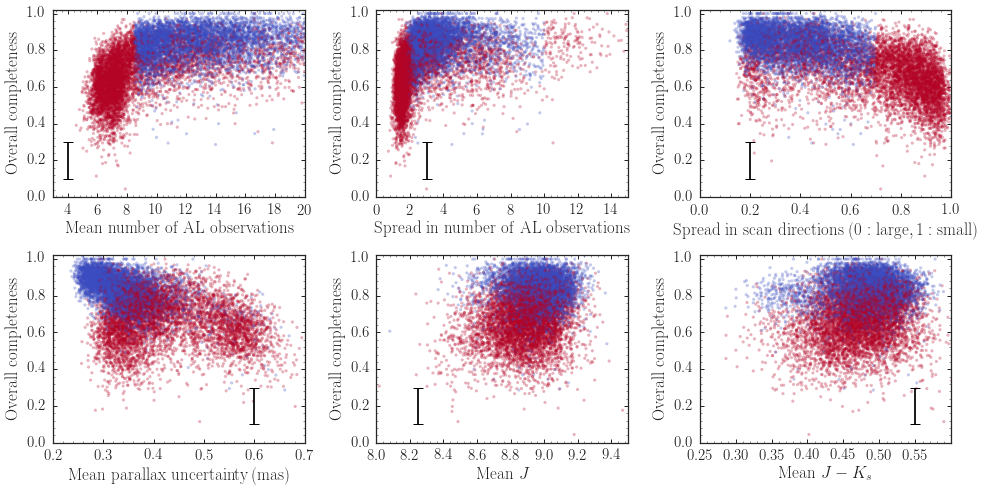

In [11]:
figsize(14,7)
overall_completeness= nstar.astype('float')/a[1]
unc_completeness= numpy.median(numpy.sqrt(nstar.astype('float'))/a[1]) # pretty much constant
# Selection of 'good' sky
min_nobs=8.5
max_nobs_std=10.
max_scd=0.7
min_lat=20.
good= (nobs >= min_nobs)*(nobs_std <= max_nobs_std)*(mscd <= max_scd)*(numpy.fabs(elats) >= min_lat)
subplot(2,3,1)
bovy_plot.bovy_plot(nobs,overall_completeness,gcf=True,
                   xrange=[3.,20.],yrange=[0.,1.02],alpha=.3,scatter=True,
                    c=good,s=10.,edgecolors='None',cmap='coolwarm_r',vmin=0.,vmax=1.,
                   xlabel=r'$\mathrm{Mean\ number\ of\ AL\ observations}$',
                   ylabel=r'$\mathrm{Overall\ completeness}$')
def add_unc_errorbar(xloc):
    (_, caps, _)= pyplot.errorbar(xloc,0.2,yerr=unc_completeness,marker='None',ls='none',capsize=5,color='k')
    for cap in caps: #Why oh why?
        cap.set_color('k')
        cap.set_markeredgewidth(1)
add_unc_errorbar(4.)
subplot(2,3,2)
bovy_plot.bovy_plot(nobs_std,overall_completeness,gcf=True,rasterized=True,
                   xrange=[0.,15.],yrange=[0.,1.02],alpha=.3,scatter=True,
                    c=good,s=10.,edgecolors='None',cmap='coolwarm_r',vmin=0.,vmax=1.,
                   xlabel=r'$\mathrm{Spread\ in\ number\ of\ AL\ observations}$',
                   ylabel=r'$\mathrm{Overall\ completeness}$')
add_unc_errorbar(3.)
subplot(2,3,3)
bovy_plot.bovy_plot(mscd,nstar.astype('float')/a[1],gcf=True,rasterized=True,
                    xrange=[0.,1.],yrange=[0.,1.02],alpha=.3,scatter=True,
                    c=good,s=10.,edgecolors='None',cmap='coolwarm_r',vmin=0.,vmax=1.,
                   xlabel=r'$\mathrm{Spread\ in\ scan\ directions\ (0: large, 1: small)}$',
                   ylabel=r'$\mathrm{Overall\ completeness}$')
add_unc_errorbar(.2)
subplot(2,3,4)
bovy_plot.bovy_plot(mplxerr,nstar.astype('float')/a[1],gcf=True,rasterized=True,
                    xrange=[0.2,.7],yrange=[0.,1.02],alpha=.3,scatter=True,
                    c=good,s=10.,edgecolors='None',cmap='coolwarm_r',vmin=0.,vmax=1.,
                    xlabel=r'$\mathrm{Mean\ parallax\ uncertainty}\,(\mathrm{mas})$',
                    ylabel=r'$\mathrm{Overall\ completeness}$')
add_unc_errorbar(.6)
subplot(2,3,5)
bovy_plot.bovy_plot(mj,nstar.astype('float')/a[1],gcf=True,rasterized=True,
                   xrange=[8.,9.5],yrange=[0.,1.02],alpha=.3,scatter=True,
                    c=good,s=10.,edgecolors='None',cmap='coolwarm_r',vmin=0.,vmax=1.,
                   xlabel=r'$\mathrm{Mean}\ J$',
                   ylabel=r'$\mathrm{Overall\ completeness}$')
add_unc_errorbar(8.25)
subplot(2,3,6)
bovy_plot.bovy_plot(mjk,nstar.astype('float')/a[1],gcf=True,rasterized=True,
                   xrange=[0.25,0.6],yrange=[0.,1.02],alpha=.3,scatter=True,
                    c=good,s=10.,edgecolors='None',cmap='coolwarm_r',vmin=0.,vmax=1.,
                   xlabel=r'$\mathrm{Mean}\ J-K_s$',
                   ylabel=r'$\mathrm{Overall\ completeness}$')
add_unc_errorbar(0.55)
tight_layout()
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','props_comp_sky.pdf'),
                   bbox_inches='tight')

The overall completeness on the good part of the sky is:

Fraction of the sky covered: 0.48


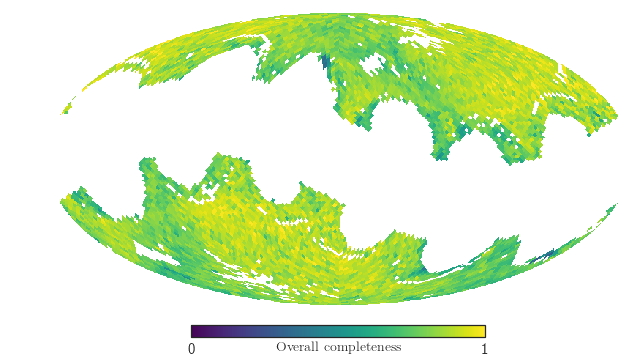

In [12]:
exclude_mask= (nobs < min_nobs)+(nobs_std > max_nobs_std)+(numpy.fabs(elats) < min_lat)+(mscd > max_scd)
pt= overall_completeness
pt[exclude_mask]= numpy.nan
healpy.mollview(pt,nest=True,unit=r'$\mathrm{Overall\ completeness}$',cmap=cmap,min=0.,max=1.,title="")
print("Fraction of the sky covered: %.2f" % (1.-numpy.sum(numpy.isnan(pt))/float(len(nobs))))
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','overall_comp.pdf'),
                   bbox_inches='tight')

## Color-magnitude dependence of the *TGAS* selection function in the 'good' part of the sky

Now that we have a good sense of the overall completeness of *TGAS* and we have isolated a 'good' part of the sky where the selection is (a) highly complete and (b) highly uniform, we look more closely at any color and magnitude dependence of the *TGAS* selection function. For this we collect *2MASS* counts in color and magnitude and compare them to *TGAS* counts. We start by looking at counts in $(J-K_s,J)$ in the 'good' part of the sky:

In [13]:
# The following needs to be performed on the server with the 2MASS database, note that the " might get messed up
"""
import psycopg2
conn= psycopg2.connect("dbname=catalogs user=postgres")
cur= conn.cursor()
cur.execute("select floor(j_m*10), floor((j_m-k_m)*20), floor(hp12index/16384), count(*) as count \
from twomass_psc, twomass_psc_hp12 \
where (twomass_psc.pts_key = twomass_psc_hp12.pts_key \
AND (ph_qual like 'A__' OR (rd_flg like '1__' OR rd_flg like '3__')) \
AND (ph_qual like '__A' OR (rd_flg like '__1' OR rd_flg like '__3')) AND use_src='1' AND ext_key is null \
AND (j_m-k_m) > -0.05 AND (j_m-k_m) < 1.0 AND j_m < 14)\
group by floor(j_m*10),floor((j_m-k_m)*20),floor(hp12index/16384) \
order by floor(j_m*10) ASC;")
import numpy
a= numpy.array(cur.fetchall(),dtype='float')
numpy.savetxt('2massc_jk_j_hp5.txt',a)
"""
a= numpy.loadtxt('2massc_jk_j_hp5.txt').T
# Make value center of bin and re-normalize
a[0]+= 0.5
a[1]+= 0.5
a[0]/= 10.
a[1]/= 20.

In [14]:
tbins= bins=[145,25,healpy.nside2npix(nside)]
trange=[[0,14.5],[-0.15,1.1],[-0.5,healpy.nside2npix(nside)-0.5]]
nstar2mass, edges= numpy.histogramdd(a[:3].T,bins=tbins,range=trange,weights=a[3])
findx= (jk > -0.05)*(jk < 1.0)*(twomass['j_mag'] < 14.)
nstartgas, edges= numpy.histogramdd(numpy.array([twomass['j_mag'][findx],
                                                twomass['j_mag'][findx]-twomass['k_mag'][findx],
                                                sid[findx]]).T,
                                    bins=tbins,range=trange)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1210: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



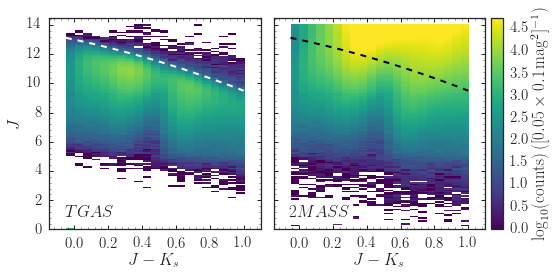

In [15]:
figsize(7,4)
nstar2mass[:,:,exclude_mask]= numpy.nan
nstartgas[:,:,exclude_mask]= numpy.nan
vmin= 0.
vmax= 4.75
subplot(1,2,1)
bovy_plot.bovy_dens2d(numpy.log10(numpy.nansum(nstartgas,axis=-1)),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$J-K_s$',ylabel=r'$J$')
xs= numpy.linspace(-0.05,1.,101)
plot(xs,13.-(xs**2.+2.5*xs),'w',lw=2.,ls='--')
t= pyplot.annotate(r'$TGAS$',(0.075,0.06),xycoords='axes fraction',size=17.)
t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
subplot(1,2,2)
bovy_plot.bovy_dens2d(numpy.log10(numpy.nansum(nstar2mass,axis=-1)),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$J-K_s$')
t= pyplot.annotate(r'$2MASS$',(0.075,0.06),xycoords='axes fraction',size=17.)
t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
gca().yaxis.set_major_formatter(NullFormatter())
plot(xs,13.-(xs**2.+2.5*xs),'k',lw=2.,ls='--')
fig= pyplot.gcf()
fig.subplots_adjust(right=0.925)
cbar_ax = fig.add_axes([0.985, 0.17, 0.025, 0.7325])
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True)#,format=fmt)
cbar.set_label(r'$\log_{10} (\mathrm{counts})\,([0.05\times0.1\,\mathrm{mag}^{2}]^{-1})$')
tight_layout()
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','cmds_2m_tg.pdf'),
                   bbox_inches='tight')

The ratio---the completeness---is:

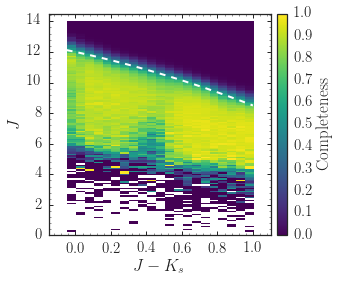

In [16]:
figsize(4,4)
vmin= 0.
vmax= 1.
bovy_plot.bovy_dens2d(numpy.nansum(nstartgas,axis=-1)/numpy.nansum(nstar2mass,axis=-1),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$J-K_s$',ylabel=r'$J$')
plot(xs,12.-(xs**2.+2.5*xs),'w',lw=2.,ls='--')
fig= pyplot.gcf()
fig.subplots_adjust(right=0.955)
cbar_ax = fig.add_axes([0.965, 0.185, 0.035, 0.77])
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True)#,format=fmt)
cbar.set_label(r'$\mathrm{Completeness}$')
tight_layout()
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','comp_j_jk.pdf'),
                   bbox_inches='tight')

Let's collapse this to the magnitude distribution:

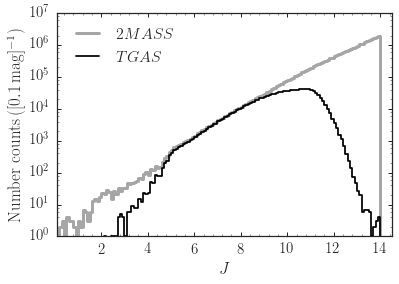

In [17]:
figsize(6,4)
js= 0.5*(numpy.roll(edges[0],1)+edges[0])[1:]
line1= bovy_plot.bovy_plot(js,numpy.nansum(numpy.nansum(nstartgas,axis=-1),axis=-1),ls='steps-mid',
                        color='k',
                        xlabel=r'$J$',ylabel=r'$\mathrm{Number\ counts}\,([0.1\,\mathrm{mag}]^{-1})$',
                        xrange=[0.1,14.5],yrange=[1.,10.**7.],
                        semilogy=True,zorder=2)
line2= bovy_plot.bovy_plot(js,numpy.nansum(numpy.nansum(nstar2mass,axis=-1),axis=-1),ls='steps-mid',
                           color='0.65',lw=3.,overplot=True,zorder=1)
pyplot.legend((line2[0],line1[0]),
                (r'$2MASS$',
                 r'$TGAS$'),
                  loc='upper left',#bbox_to_anchor=(.91,.375),
                  numpoints=8,
                  prop={'size':16},
                  frameon=False)
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','magdist_j.pdf'),
                   bbox_inches='tight')

Because the completeness appears to have a simple color-dependence (delineated by the dashed lines in the color-magnitude distributions above), we now query the 2MASS database to get counts in a transformed $J_G$ that corrects for the color dependence as

$J_G = J + (J-K_s)^2 + 2.5\, (J-K_s)$:

In [18]:
# The following needs to be performed on the server with the 2MASS database, note that the " might get messed up
"""
import psycopg2
conn= psycopg2.connect("dbname=catalogs user=postgres")
cur= conn.cursor()
cur.execute("select floor((j_m+(j_m-k_m)*(j_m-k_m)+2.5*(j_m-k_m))*10), \
floor((j_m-k_m)*20), floor(hp12index/16384), count(*) as count \
from twomass_psc, twomass_psc_hp12 \
where (twomass_psc.pts_key = twomass_psc_hp12.pts_key \
AND (ph_qual like 'A__' OR (rd_flg like '1__' OR rd_flg like '3__')) \
AND (ph_qual like '__A' OR (rd_flg like '__1' OR rd_flg like '__3')) AND use_src='1' AND ext_key is null \
AND (j_m-k_m) > -0.05 AND (j_m-k_m) < 1.0 AND j_m < 14)\
group by floor((j_m+(j_m-k_m)*(j_m-k_m)+2.5*(j_m-k_m))*10), \
floor((j_m-k_m)*20),floor(hp12index/16384) \
order by floor((j_m+(j_m-k_m)*(j_m-k_m)+2.5*(j_m-k_m))*10) ASC;")
import numpy
a= numpy.array(cur.fetchall(),dtype='float')
numpy.savetxt('2massc_jk_jt_hp5.txt',a)
"""
a= numpy.loadtxt('2massc_jk_jt_hp5.txt').T
# Make value center of bin and re-normalize
a[0]+= 0.5
a[1]+= 0.5
a[0]/= 10.
a[1]/= 20.

In [19]:
tbins= bins=[145,25,healpy.nside2npix(nside)]
trange=[[0,14.5],[-0.15,1.1],[-0.5,healpy.nside2npix(nside)-0.5]]
nstar2mass, edges= numpy.histogramdd(a[:3].T,bins=tbins,range=trange,weights=a[3])
findx= (jk > -0.05)*(jk < 1.0)*(twomass['j_mag'] < 14.)
nstartgas, edges= numpy.histogramdd(numpy.array([gaia_tools.select.jt(jk[findx],twomass['j_mag'][findx]),
                                                twomass['j_mag'][findx]-twomass['k_mag'][findx],
                                                sid[findx]]).T,
                                    bins=tbins,range=trange)

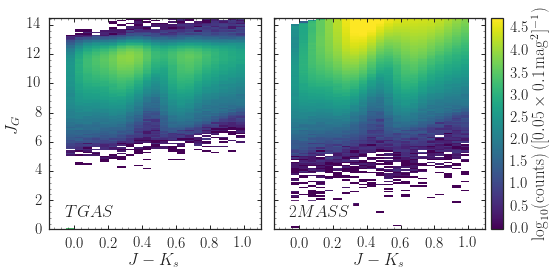

In [20]:
figsize(7,4)
nstar2mass[:,:,exclude_mask]= numpy.nan
nstartgas[:,:,exclude_mask]= numpy.nan
vmin= 0.
vmax= 4.75
subplot(1,2,1)
bovy_plot.bovy_dens2d(numpy.log10(numpy.nansum(nstartgas,axis=-1)),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$J-K_s$',ylabel=r'$J_G$')
t= pyplot.annotate(r'$TGAS$',(0.075,0.06),xycoords='axes fraction',size=17.)
t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
subplot(1,2,2)
bovy_plot.bovy_dens2d(numpy.log10(numpy.nansum(nstar2mass,axis=-1)),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$J-K_s$')
t= pyplot.annotate(r'$2MASS$',(0.075,0.06),xycoords='axes fraction',size=17.)
t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
gca().yaxis.set_major_formatter(NullFormatter())
fig= pyplot.gcf()
fig.subplots_adjust(right=0.925)
cbar_ax = fig.add_axes([0.985, 0.17, 0.025, 0.7325])
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True)#,format=fmt)
cbar.set_label(r'$\log_{10} (\mathrm{counts})\,([0.05\times0.1\,\mathrm{mag}^{2}]^{-1})$')
tight_layout()

The completeness is now:

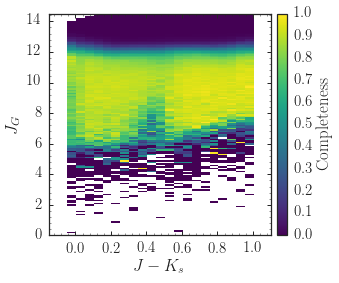

In [21]:
figsize(4,4)
vmin= 0.
vmax= 1.
bovy_plot.bovy_dens2d(numpy.nansum(nstartgas,axis=-1)/numpy.nansum(nstar2mass,axis=-1),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$J-K_s$',ylabel=r'$J_G$')
fig= pyplot.gcf()
fig.subplots_adjust(right=0.955)
cbar_ax = fig.add_axes([0.965, 0.185, 0.035, 0.77])
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True)#,format=fmt)
cbar.set_label(r'$\mathrm{Completeness}$')
tight_layout()
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','comp_jg_jk.pdf'),
                   bbox_inches='tight')

and the magnitude distribution in $J_G$ is

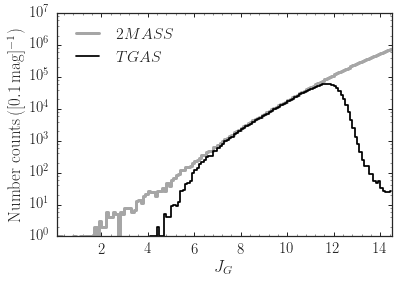

In [22]:
figsize(6,4)
js= 0.5*(numpy.roll(edges[0],1)+edges[0])[1:]
line1= bovy_plot.bovy_plot(js,numpy.nansum(numpy.nansum(nstartgas,axis=-1),axis=-1),ls='steps-mid',
                        color='k',
                        xlabel=r'$J_G$',ylabel=r'$\mathrm{Number\ counts}\,([0.1\,\mathrm{mag}]^{-1})$',
                        xrange=[0.1,14.5],yrange=[1.,10.**7.],
                        semilogy=True,zorder=2)
line2= bovy_plot.bovy_plot(js,numpy.nansum(numpy.nansum(nstar2mass,axis=-1),axis=-1),ls='steps-mid',
                           color='0.65',lw=3.,overplot=True,zorder=1)
pyplot.legend((line2[0],line1[0]),
                (r'$2MASS$',
                 r'$TGAS$'),
                  loc='upper left',#bbox_to_anchor=(.91,.375),
                  numpoints=8,
                  prop={'size':16},
                  frameon=False)
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','magdist_jg.pdf'),
                   bbox_inches='tight')

Let's now compare to the model for the selection function:

In [23]:
tsf= gaia_tools.select.tgasSelect()

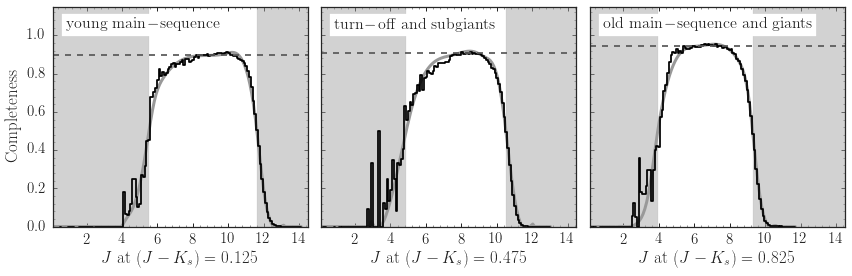

In [24]:
figsize(12,4)
js= 0.5*(numpy.roll(edges[0],1)+edges[0])[1:]
#Three main color bins
jks= 0.35/2.+numpy.array([-0.05,0.3,0.65])
labels= [r'$\mathrm{young\ main\!-\!sequence}$',
         r'$\mathrm{turn\!-\!off\ and\ subgiants}$',
         r'$\mathrm{old\ main\!-\!sequence\ and\ giants}$']
for ii in range(3):
    subplot(1,3,ii+1)
    if ii == 0:
        ylabel= r'$\mathrm{Completeness}$'
    else:
        ylabel= None
    jshift= (jks**2.+2.5*jks)[ii]
    bovy_plot.bovy_plot(js-jshift,
                        numpy.nansum(numpy.nansum(nstartgas,axis=-1)[:,2+ii*7:-3-(2-ii)*7],axis=-1)\
                        /numpy.nansum(numpy.nansum(nstar2mass,axis=-1)[:,2+ii*7:-3-(2-ii)*7],axis=-1),
                        ls='steps-mid',gcf=True,
                        color='k',
                        xlabel=r'$J\ \mathrm{at}\ (J-K_s) = %.3f$' % jks[ii],
                        ylabel=ylabel,
                        xrange=[0.1,14.5],yrange=[0.,1.15],zorder=2)
    plot(js-jshift,tsf._sf_splines[ii](js),color='0.6',lw=3.,zorder=1)
    pyplot.axhline(tsf._sf_props[ii,0],color='0.35',ls='--')
    pyplot.fill_between([0.,tsf._sf_props[ii,1]-jshift],[0.,0.],[1.2,1.2],color='0.65',alpha=0.5)
    pyplot.fill_between([tsf._sf_props[ii,2]-jshift,15.],[0.,0.],[1.2,1.2],color='0.65',alpha=0.5)
    if ii > 0: gca().yaxis.set_major_formatter(NullFormatter())
    t= pyplot.annotate(labels[ii],(0.05,0.9),xycoords='axes fraction',size=16.)
    t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
tight_layout()
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','comp_3jbins.pdf'),
                   bbox_inches='tight')

## Color-magnitude dependence of the *TGAS* selection function in the 'bad' parts of the sky

Now let's take a look at the 'bad' part of the sky, that is, the part of the sky that didn't pass the high-quality cuts above. First we investigate how the bad area is distributed in terms of the number of observations, the spread in the observations, the ecliptic latitude, and the spread in scan directions:

In [25]:
print("Total number of pixels excluded:",
      numpy.sum((nobs < min_nobs)+(nobs_std > max_nobs_std)+(numpy.fabs(elats) < min_lat)+(mscd > max_scd)))
print("Number of pixels excluded, just ecliptic:",
      numpy.sum((nobs >= min_nobs)*(mscd <= max_scd)*(nobs_std <= max_nobs_std)*(numpy.fabs(elats) < min_lat)))
print("Number of pixels excluded, max_nobs_std:",
      numpy.sum((nobs >= min_nobs)*(mscd <= max_scd)*(nobs_std > max_nobs_std)*(numpy.fabs(elats) >= min_lat)))
print("Number of pixels excluded, min_nobs, mscd good (all ecl+max_nobs+std):",
      numpy.sum((nobs < min_nobs)*(mscd <= max_scd)))
print("Number of pixels excluded, mscd, min_nobs good (all ecl+max_nobs+std):",
      numpy.sum((nobs >= min_nobs)*(mscd > max_scd)))
print("Number of pixels excluded, mscd & min_nobs bad (all ecl+max_nobs+std):",
      numpy.sum((nobs < min_nobs)*(mscd > max_scd)))

('Total number of pixels excluded:', 6432)
('Number of pixels excluded, just ecliptic:', 1353)
('Number of pixels excluded, max_nobs_std:', 160)
('Number of pixels excluded, min_nobs, mscd good (all ecl+max_nobs+std):', 817)
('Number of pixels excluded, mscd, min_nobs good (all ecl+max_nobs+std):', 599)
('Number of pixels excluded, mscd & min_nobs bad (all ecl+max_nobs+std):', 3496)


Now let's take a look at the overall completeness for these different cuts:

In [26]:
a= numpy.loadtxt('2massc_hp5.txt').T
# Make sure all HEALPix bins are represented (this is the case, but just to make sure)
ta= numpy.zeros((2,healpy.nside2npix(nside)))
ta[0][a[0].astype('int')]= a[0]
ta[1][a[0].astype('int')]= a[1]
a= ta
overall_completeness= nstar.astype('float')/a[1]
unc_completeness= numpy.median(numpy.sqrt(nstar.astype('float'))/a[1]) # pretty much constant

The entire part of the sky that is considered to be bad:

Fraction of the sky covered: 0.52


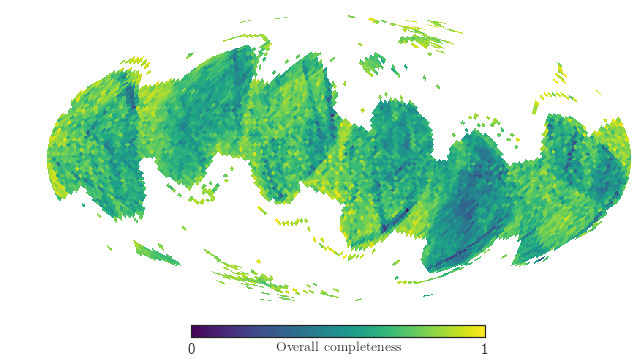

In [27]:
exclude_mask= True-((nobs < min_nobs)+(nobs_std > max_nobs_std)+(numpy.fabs(elats) < min_lat)+(mscd > max_scd))
overall_completeness= nstar.astype('float')/a[1]
unc_completeness= numpy.median(numpy.sqrt(nstar.astype('float'))/a[1]) # pretty much constant
pt= overall_completeness
pt[exclude_mask]= numpy.nan
healpy.mollview(pt,nest=True,unit=r'$\mathrm{Overall\ completeness}$',cmap=cmap,min=0.,max=1.,title="")
print("Fraction of the sky covered: %.2f" % (1.-numpy.sum(numpy.isnan(pt))/float(len(nobs))))
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','overall_comp_bad.pdf'),
                   bbox_inches='tight')

Pixels just failing the Ecliptic latitude cut:

Fraction of the sky covered: 0.11


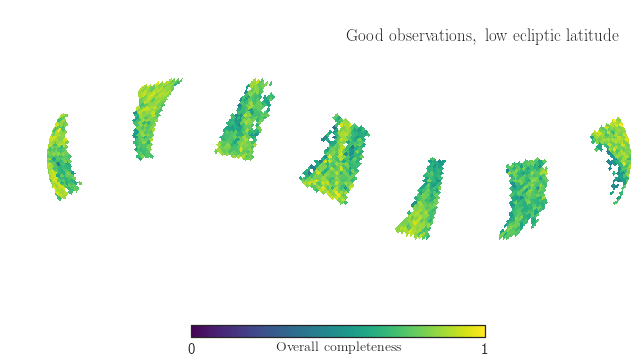

In [28]:
exclude_mask= True-((nobs >= min_nobs)*(mscd <= max_scd)*(nobs_std <= max_nobs_std)*(numpy.fabs(elats) < min_lat))
overall_completeness= nstar.astype('float')/a[1]
unc_completeness= numpy.median(numpy.sqrt(nstar.astype('float'))/a[1]) # pretty much constant
pt= overall_completeness
pt[exclude_mask]= numpy.nan
healpy.mollview(pt,nest=True,unit=r'$\mathrm{Overall\ completeness}$',cmap=cmap,min=0.,max=1.,title="")
bovy_plot.bovy_text(0.05,0.8,r"$\mathrm{Good\ observations,\ low\ ecliptic\ latitude}$",size=17.)
print("Fraction of the sky covered: %.2f" % (1.-numpy.sum(numpy.isnan(pt))/float(len(nobs))))
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','overall_comp_lowlat.pdf'),
                   bbox_inches='tight')

These are quite consistent with those that don't fail the Ecliptic latitude cut, so the simplest assumption is to use the same selection function derived for the 'good' part of the sky.

Those failing the n_obs cut, but having a good spread in scan directions:

Fraction of the sky covered: 0.07


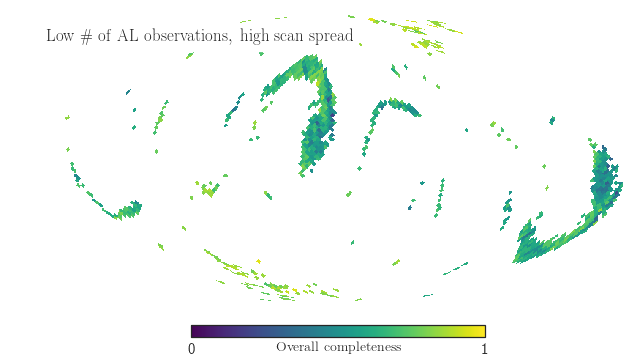

In [29]:
exclude_mask= True-((nobs < min_nobs)*(mscd <= max_scd))
overall_completeness= nstar.astype('float')/a[1]
unc_completeness= numpy.median(numpy.sqrt(nstar.astype('float'))/a[1]) # pretty much constant
pt= overall_completeness
pt[exclude_mask]= numpy.nan
healpy.mollview(pt,nest=True,unit=r'$\mathrm{Overall\ completeness}$',cmap=cmap,min=0.,max=1.,title="")
bovy_plot.bovy_text(-2.,0.8,r"$\mathrm{Low\ \#\ of\ AL\ observations,\ high\ scan\ spread}$",size=17.,
                    backgroundcolor='w')
print("Fraction of the sky covered: %.2f" % (1.-numpy.sum(numpy.isnan(pt))/float(len(nobs))))
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','overall_comp_lownobs.pdf'),
                   bbox_inches='tight')

Those having enough observations, but not a good spread in scan directions:

Fraction of the sky covered: 0.05


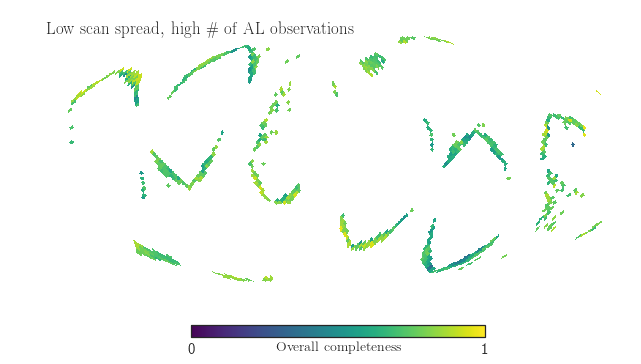

In [30]:
exclude_mask= True-((nobs >= min_nobs)*(mscd > max_scd))
overall_completeness= nstar.astype('float')/a[1]
unc_completeness= numpy.median(numpy.sqrt(nstar.astype('float'))/a[1]) # pretty much constant
pt= overall_completeness
pt[exclude_mask]= numpy.nan
healpy.mollview(pt,nest=True,unit=r'$\mathrm{Overall\ completeness}$',cmap=cmap,min=0.,max=1.,title="")
bovy_plot.bovy_text(-2.,0.85,r"$\mathrm{Low\ scan\ spread,\ high\ \#\ of\ AL\ observations}$",size=17.,
                    backgroundcolor='w')
print("Fraction of the sky covered: %.2f" % (1.-numpy.sum(numpy.isnan(pt))/float(len(nobs))))
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','overall_comp_lowscan.pdf'),
                   bbox_inches='tight')

and pixels that have neither enough observations or a good enough spread in the scan directions:

Fraction of the sky covered: 0.28


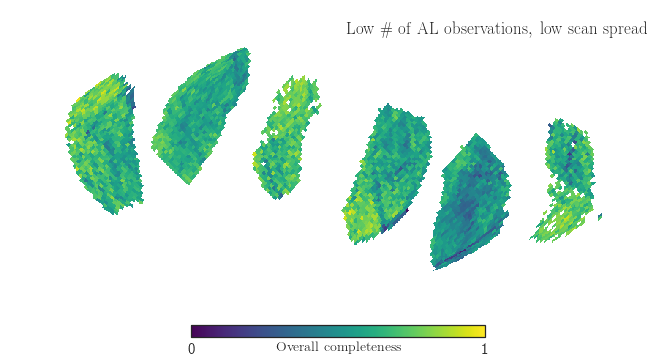

In [31]:
exclude_mask= True-((nobs < min_nobs)*(mscd > max_scd))
overall_completeness= nstar.astype('float')/a[1]
unc_completeness= numpy.median(numpy.sqrt(nstar.astype('float'))/a[1]) # pretty much constant
pt= overall_completeness
pt[exclude_mask]= numpy.nan
healpy.mollview(pt,nest=True,unit=r'$\mathrm{Overall\ completeness}$',cmap=cmap,min=0.,max=1.,title="")
bovy_plot.bovy_text(0.05,0.85,r"$\mathrm{Low\ \#\ of\ AL\ observations,\ low\ scan\ spread}$",size=17.,
                   backgroundcolor='w')
print("Fraction of the sky covered: %.2f" % (1.-numpy.sum(numpy.isnan(pt))/float(len(nobs))))
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','overall_comp_badbad.pdf'),
                   bbox_inches='tight')

These 6 patches can be split simply based on their Ecliptic longitude at intervals of 60 (exactly 60!).

# Test against Tycho-2

We test the model for the selection function by comparing the counts predicted by Tycho-2 x TGAS-selection-function to the TGAS counts down to V ~ 11 where Tycho-2 is 99% complete. First we read the Tycho-2 data and match it against TGAS

In [32]:
from gaia_tools import xmatch
import astropy.io.ascii
from astropy.table import Table, Column

In [33]:
# create tyc2, matched to tgas
tyc2_savefilename= 'tyc2_radecbtvt_tgasmatched.npy'
if not os.path.exists(tyc2_savefilename):
    tyc2_raw= astropy.io.ascii.read('/Users/bovy/data/gaia_tools/Tycho2/tyc2.dat',
                                    readme='/Users/bovy/data/gaia_tools/Tycho2/ReadMe',
                                    format='cds')
    tyc2_raw_sub= Table([tyc2_raw['RAmdeg'],
                         tyc2_raw['DEmdeg'],
                         tyc2_raw['BTmag'],
                         tyc2_raw['VTmag']])
    m1,m2,sep= xmatch.xmatch(tyc2_raw_sub,tgas,colRA1='RAmdeg',colDec1='DEmdeg',
                             colRA2='ra',colDec2='dec',epoch2=2015.)
    tyc2_raw_sub= tyc2_raw_sub[m1]
    tyc2= numpy.zeros((4,len(tgas)))-1
    tyc2[0,m2]= tyc2_raw_sub['RAmdeg']
    tyc2[1,m2]= tyc2_raw_sub['DEmdeg']
    tyc2[2,m2]= tyc2_raw_sub['BTmag']
    tyc2[3,m2]= tyc2_raw_sub['VTmag']
    numpy.save(tyc2_savefilename,tyc2)
else:
    tyc2= numpy.load(tyc2_savefilename)
tyc2_tmp= Table()
tyc2_tmp['RAmdeg']= Column(tyc2[0],unit='deg',description='Mean Right Asc, ICRS, epoch=J2000')
tyc2_tmp['DEmdeg']= Column(tyc2[1],unit='deg',description='Mean Decl, ICRS, at epoch=J2000')
tyc2_tmp['BTmag']= Column(tyc2[2],unit='mag',description='Tycho-2 BT magnitude')
tyc2_tmp['VTmag']= Column(tyc2[3],unit='mag',description='Tycho-2 VT magnitude')
tyc2m= tyc2_tmp
btvtm= (tyc2m['BTmag']-tyc2m['VTmag'])

## Color-color transformations between Tycho-2 $(B_T,V_T)$ and 2MASS $(J,K_S)$

We determine relations between the $B_T-V_T$, $V_T-J$, and $J-K_S$ colors based on bright stars with small photometric uncertainties. Here is $J-K_S$ vs. $B_T-V_T$:

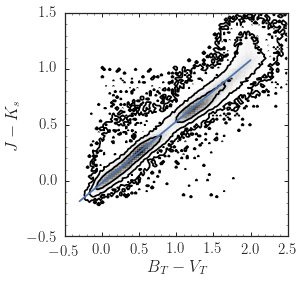

In [34]:
mt2indx= (tyc2m['BTmag'] > -1)*(jk != 0.)*(tyc2m['VTmag'] < 9.5)
figsize(6,4)
bovy_plot.scatterplot(btvtm[mt2indx],jk[mt2indx],'k,',ms=0.,                    
                     xrange=[-0.5,2.5],yrange=[-0.5,1.5],
                     xlabel=r'$B_T-V_T$',
                     ylabel=r'$J-K_s$')
pjk= [0.55,-0.02]
#rndindx= numpy.random.permutation(numpy.sum(mt2indx))[:1000]
#pjk= numpy.polyfit(btvtm[mt2indx][rndindx],jk[mt2indx][rndindx],deg=1)
#print(pjk)
bvs= numpy.linspace(-0.3,2.,101)
plot(bvs,numpy.polyval(pjk,bvs),'-')

and $V_T-J$ vs. $B_T-V_T$

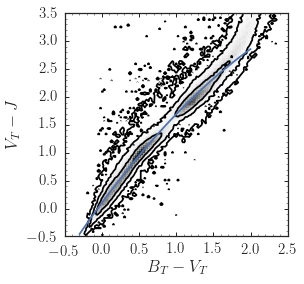

In [35]:
mt2indx= (tyc2m['BTmag'] > -1)*(jk != 0.)*(tyc2m['VTmag'] < 9.5)
figsize(6,4)
bovy_plot.scatterplot(btvtm[mt2indx],(tyc2m['VTmag']-twomass['j_mag'])[mt2indx],
                      'k,',ms=0.,                    
                      xrange=[-0.5,2.5],yrange=[-0.5,3.5],
                      xlabel=r'$B_T-V_T$',
                      ylabel=r'$V_T-J$')
pvj= [-0.21,1.8,0.1]
#mt2indx= (tyc2m['BTmag'] > -1)*(jk != 0.)*(tyc2m['VTmag'] < 9.5)*(jk < 1.)
#rndindx= numpy.random.permutation(numpy.sum(mt2indx))[:100]
#pvj= numpy.polyfit(btvtm[mt2indx][rndindx],(tyc2m['VTmag']-twomass['j_mag'])[mt2indx][rndindx],deg=2)
#print(pvj)
bvs= numpy.linspace(-0.3,2.,101)
plot(bvs,numpy.polyval(pvj,bvs),'-')

In [36]:
def jk_from_bv(bv):
    return numpy.polyval(pjk,bv)
def vj_from_bv(bv):
    return numpy.polyval(pvj,bv)
def j_from_vbv(bv,v):
    return v-vj_from_bv(bv)

## TGAS completeness vs. Tycho-2

Now we compute the TGAS completeness by comparing it to Tycho-2 and we predict this completeness using the model derived from comparing TGAS to 2MASS. First we read the full Tycho-2 catalog:

In [37]:
# create tyc2
tyc2_savefilename= 'tyc2_radecbtvt.npy'
if not os.path.exists(tyc2_savefilename):
    tyc2_raw= astropy.io.ascii.read('/Users/bovy/data/gaia_tools/Tycho2/tyc2.dat',
                                    readme='/Users/bovy/data/gaia_tools/Tycho2/ReadMe',
                                    format='cds')
    tyc2= numpy.zeros((5,len(tyc2_raw)))-1
    tyc2[0]= tyc2_raw['RAmdeg']
    tyc2[1]= tyc2_raw['DEmdeg']
    tyc2[2]= tyc2_raw['BTmag']
    tyc2[3]= tyc2_raw['VTmag']
    tyc2[4]= healpy.ang2pix(nside,numpy.pi/2.-tyc2[1]/180.*numpy.pi,tyc2[0]/180.*numpy.pi,nest=True)
    numpy.save(tyc2_savefilename,tyc2)
else:
    tyc2= numpy.load(tyc2_savefilename)
tyc2_tmp= Table()
tyc2_tmp['RAmdeg']= Column(tyc2[0],unit='deg',description='Mean Right Asc, ICRS, epoch=J2000')
tyc2_tmp['DEmdeg']= Column(tyc2[1],unit='deg',description='Mean Decl, ICRS, at epoch=J2000')
tyc2_tmp['BTmag']= Column(tyc2[2],unit='mag',description='Tycho-2 BT magnitude')
tyc2_tmp['VTmag']= Column(tyc2[3],unit='mag',description='Tycho-2 VT magnitude')
tyc2_tmp['hp5']= Column(tyc2[4],unit='',description='HEALPix level 5 index')
tyc2= tyc2_tmp
btvt= (tyc2['BTmag']-tyc2['VTmag'])

The overall star counts down to $V_T = 11$ in Tycho-2 are:

In [38]:
findx= (btvt > 0.)*(btvt < 1.5)*(tyc2['VTmag'] < 11.)
nstar, e= numpy.histogram(tyc2['hp5'][findx],range=[-0.5,healpy.nside2npix(nside)-0.5],bins=healpy.nside2npix(nside))

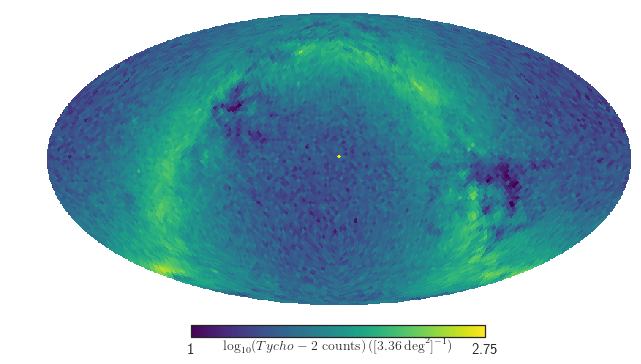

In [39]:
healpy.mollview(numpy.log10(nstar),nest=True,
                unit=r'$\log_{10} (Tycho-2\ \mathrm{counts})\,([%.2f\,\mathrm{deg}^2]^{-1})$' \
                    % (healpy.nside2pixarea(nside,degrees=True)),
                cmap=cmap,min=1.,max=2.75,title="")

Now, we compare the counts in *TGAS* and in *Tycho-2* in the 'good' part of the sky:

In [40]:
# Go back to original exclude_mask
exclude_mask= (nobs < min_nobs)+(nobs_std > max_nobs_std)+(numpy.fabs(elats) < min_lat)+(mscd > max_scd)

In [41]:
tbins= bins=[145//2,15,healpy.nside2npix(nside)]
trange=[[0,14.4],[0.,1.5],[-0.5,healpy.nside2npix(nside)-0.5]]
findx= (btvtm > 0.)*(btvtm < 1.5)*(tyc2m['VTmag'] < 15.)
nstartgas, edges= numpy.histogramdd(numpy.array([tyc2m['VTmag'][findx],
                                                tyc2m['BTmag'][findx]-tyc2m['VTmag'][findx],
                                                sid[findx]]).T,
                                    bins=tbins,range=trange)
findx= (btvt > 0.)*(btvt < 1.5)*(tyc2['VTmag'] < 15.)
nstartyc2, edges= numpy.histogramdd(numpy.array([tyc2['VTmag'][findx],
                                                tyc2['BTmag'][findx]-tyc2['VTmag'][findx],
                                                tyc2['hp5'][findx]]).T,
                                    bins=tbins,range=trange)

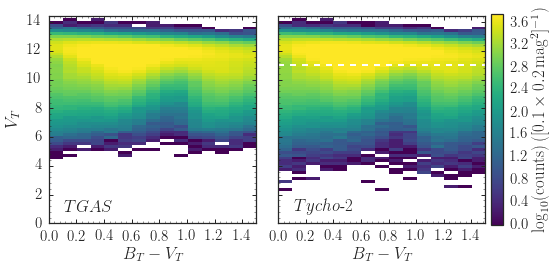

In [42]:
figsize(7,4)
nstartyc2[:,:,exclude_mask]= numpy.nan
nstartgas[:,:,exclude_mask]= numpy.nan
vmin= 0.
vmax= 3.75
subplot(1,2,1)
bovy_plot.bovy_dens2d(numpy.log10(numpy.nansum(nstartgas,axis=-1)),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$B_T-V_T$',ylabel=r'$V_T$')
t= pyplot.annotate(r'$TGAS$',(0.075,0.06),xycoords='axes fraction',size=17.)
t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
subplot(1,2,2)
bovy_plot.bovy_dens2d(numpy.log10(numpy.nansum(nstartyc2,axis=-1)),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$B_T-V_T$')
t= pyplot.annotate(r'$Tycho\hbox{-}2$',(0.075,0.06),xycoords='axes fraction',size=17.)
axhline(11.,ls='--',color='w',lw=2.)
t.set_bbox(dict(color='w', alpha=1.,edgecolor='None'))
gca().yaxis.set_major_formatter(NullFormatter())
fig= pyplot.gcf()
fig.subplots_adjust(right=0.925)
cbar_ax = fig.add_axes([0.985, 0.17, 0.025, 0.7325])
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True)#,format=fmt)
cbar.set_label(r'$\log_{10} (\mathrm{counts})\,([0.1\times0.2\,\mathrm{mag}^{2}]^{-1})$')
tight_layout()
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','cmds_tyc2_tg.pdf'),
                   bbox_inches='tight')

and we compute the ratio = completeness of *TGAS* versus *Tycho-2* and compare it to our model. Keep in mind that *Tycho-2* itself is only 99% complete down to V ~ 11, so we shouldn't trust its counts at fainter magnitudes. This limit is always indicated by a dashed line:

In [43]:
xs= numpy.tile(0.5*(numpy.roll(edges[0],1)+edges[0])[1:],(len(edges[1])-1,1))
ys= numpy.tile(0.5*(numpy.roll(edges[1],1)+edges[1])[1:],(len(edges[0])-1,1)).T
tjk= jk_from_bv(ys)
tj= j_from_vbv(ys,xs)
sfmodel= tsf(tj,tjk,120.,-10.)

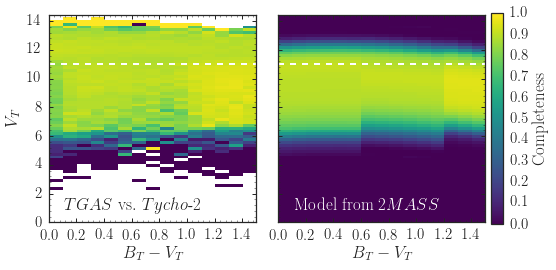

In [44]:
figsize(7,4)
vmin= 0.
vmax= 1.
subplot(1,2,1)
bovy_plot.bovy_dens2d(numpy.nansum(nstartgas,axis=-1)/numpy.nansum(nstartyc2,axis=-1),
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$B_T-V_T$',ylabel=r'$V_T$')
axhline(11.,ls='--',color='w',lw=2.)
t= pyplot.annotate(r'$TGAS\ \mathrm{vs.}\ Tycho\hbox{-}2$',(0.075,0.06),xycoords='axes fraction',size=17.)
subplot(1,2,2)
bovy_plot.bovy_dens2d(sfmodel.T,
                      origin='lower',cmap='viridis',interpolation='nearest',gcf=True,
                      vmin=vmin,vmax=vmax,
                      yrange=[edges[0][0],edges[0][-1]],
                      xrange=[edges[1][0],edges[1][-1]],
                      xlabel=r'$B_T-V_T$')
axhline(11.,ls='--',color='w',lw=2.)
t= pyplot.annotate(r'$\mathrm{Model\ from}\ 2MASS$',(0.075,0.06),xycoords='axes fraction',size=17.,color='w')
gca().yaxis.set_major_formatter(NullFormatter())
fig= pyplot.gcf()
fig.subplots_adjust(right=0.925)
cbar_ax = fig.add_axes([0.985, 0.17, 0.025, 0.7325])
sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
sm._A = []
cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True)#,format=fmt)
cbar.set_label(r'$\mathrm{Completeness}$')
tight_layout()
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','comp_vt_btvt.pdf'),
                   bbox_inches='tight')

The model works well. Let's now compare the counts as a function of $V_T$ for a bunch of bins in $B_T-V_T$:

In [45]:
tbins= bins=[145//2,6,healpy.nside2npix(nside)]
trange=[[0,14.4],[0.,1.5],[-0.5,healpy.nside2npix(nside)-0.5]]
findx= (btvtm > 0.)*(btvtm < 1.5)*(tyc2m['VTmag'] < 15.)
nstartgas, edges= numpy.histogramdd(numpy.array([tyc2m['VTmag'][findx],
                                                tyc2m['BTmag'][findx]-tyc2m['VTmag'][findx],
                                                sid[findx]]).T,
                                    bins=tbins,range=trange)
findx= (btvt > 0.)*(btvt < 1.5)*(tyc2['VTmag'] < 15.)
nstartyc2, edges= numpy.histogramdd(numpy.array([tyc2['VTmag'][findx],
                                                tyc2['BTmag'][findx]-tyc2['VTmag'][findx],
                                                tyc2['hp5'][findx]]).T,
                                    bins=tbins,range=trange)
nstartyc2[:,:,exclude_mask]= numpy.nan
nstartgas[:,:,exclude_mask]= numpy.nan
xs= numpy.tile(0.5*(numpy.roll(edges[0],1)+edges[0])[1:],(len(edges[1])-1,1))
ys= numpy.tile(0.5*(numpy.roll(edges[1],1)+edges[1])[1:],(len(edges[0])-1,1)).T
tjk= jk_from_bv(ys)
tj= j_from_vbv(ys,xs)
weis= [1.,1.,1.,1.,1.]
dx= xs[0,1]-xs[0,0]
dy= ys[1,0]-ys[0,0]
sfmodel= 0.2*(weis[0]*tsf(tj,tjk,120.,-10.)
              +weis[1]*tsf(tj+dx/4.,tjk,120.,-10.)
              +weis[2]*tsf(tj-dx/4.,tjk,120.,-10.)
              +weis[3]*tsf(tj,tjk+dy/4.,120.,-10.)
              +weis[4]*tsf(tj,tjk-dy/4.,120.,-10.))

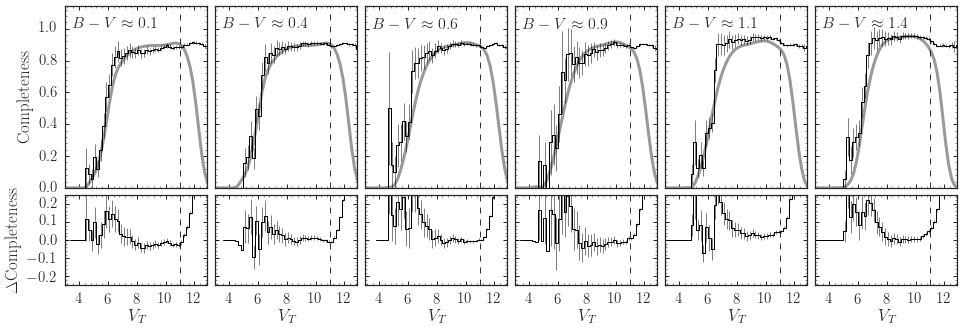

In [46]:
figsize(16,5)
gs= gridspec.GridSpec(2,len(edges[1])-1,height_ratios=[1.,.5],hspace=0.05,wspace=0.05)
for indx in range(len(edges[1])-1):
    subplot(gs[0,indx])
    if indx == 0:
        tylabel= r'$\mathrm{Completeness}$'
    else:
        tylabel= None
    bovy_plot.bovy_plot(xs[indx,:],
                        (numpy.nansum(nstartgas,axis=-1)/numpy.nansum(nstartyc2,axis=-1))[:,indx],ls='steps-mid',
                        color='k',lw=1.,
                        gcf=True,
                        xrange=[3.,12.9],
                        yrange=[0.,1.14],
                        ylabel=tylabel)
    errorbar(xs[indx,:],
             (numpy.nansum(nstartgas,axis=-1)/numpy.nansum(nstartyc2,axis=-1))[:,indx],
             yerr=numpy.sqrt(1.*(numpy.nansum(nstartgas,axis=-1)[:,indx]))/numpy.nansum(nstartyc2,axis=-1)[:,indx],
             marker='None',ls='None',color='k',capsize=0,elinewidth=0.5)
    plot(xs[indx],sfmodel[indx],color='0.6',lw=3.,zorder=1)
    axvline(11.,ls='--',lw=0.8,color='k')
    if indx > 0.: gca().yaxis.set_major_formatter(NullFormatter())
    gca().xaxis.set_major_formatter(NullFormatter())
    bovy_plot.bovy_text(r'$B-V\approx %.1f$' % ys[indx,0],top_left=True,size=16.)
    subplot(gs[1,indx])
    if indx == 0:
        tylabel= r'$\Delta\mathrm{Completeness}$'
    else:
        tylabel= None
    bovy_plot.bovy_plot(xs[indx,:],
                        (numpy.nansum(nstartgas,axis=-1)/numpy.nansum(nstartyc2,axis=-1))[:,indx]-sfmodel[indx],
                        ls='steps-mid',color='k',lw=1.,gcf=True,
                        xrange=[3.,12.9],
                        yrange=[-0.25,0.25],
                        ylabel=tylabel,
                        xlabel=r'$V_T$')
    errorbar(xs[indx,:],
             (numpy.nansum(nstartgas,axis=-1)/numpy.nansum(nstartyc2,axis=-1))[:,indx]-sfmodel[indx],
             yerr=numpy.sqrt(1.*(numpy.nansum(nstartgas,axis=-1)[:,indx]))/numpy.nansum(nstartyc2,axis=-1)[:,indx],
             marker='None',ls='None',color='k',capsize=0,elinewidth=0.5)
    axvline(11.,ls='--',lw=0.8,color='k')
    if indx > 0.: gca().yaxis.set_major_formatter(NullFormatter())
if save_figures:
    pyplot.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-tgas-completeness','comp_tyc2_bvbins.pdf'),
                   bbox_inches='tight')